# 3. Adding basic investment choices

We will continue our modeling exercise by adding investment to the model.

This will allow us to consider the policy impacts of alternative energy transition policies.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [1]:
using Pkg
Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "HiGHS","Plots", "Printf"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
using DataFrames
using CSV
using JuMP
using Ipopt, Cbc, HiGHS
using Plots
using Printf
using Statistics

Remember to set your path correctly:

In [3]:
dirpath = "/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

"/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

## Building the model

We load the same data as last week, and also clean it up to simplify it further and create the demand and import curves.

In [4]:
dfclust = CSV.read(string(dirpath,"data_jaere_clustered_100.csv"), DataFrame);

# Re-scaling (we multiply by 8.76 to make it into a full year of hours (divided by 1000))
dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

# Here only one demand type to make it easier
dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

# Calibrate demand based on elasticities (using 0.1 here as only one final demand)
elas = [.1, .2, .5, .3];
dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
dfclust.b .= mean(dfclust.b);  # average over all slopes to avoid outliers
dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

# Calibrate imports (using elas 0.3)
dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

In [5]:
dfclust

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights,demand,b,a,bm,am
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,44.8507,7.25688,15.6342,6.24111,11.3666,0.481806,0.785586,4.61597,0.0579184,33.242,0.0830825,36.9683,0.0485403,5.07982
2,40.2834,8.47216,11.5798,4.06036,14.155,0.411881,0.00733263,3.95377,0.126734,29.7952,0.0830825,33.142,0.0630941,5.93051
3,70.1554,8.07499,15.0325,6.11547,20.0267,0.398612,0.505725,5.78134,0.0363251,41.1747,0.0830825,47.0034,0.0345304,5.65249
4,26.5618,7.02309,10.0495,3.91292,8.15435,0.662615,0.0102827,3.43998,0.153373,22.1167,0.0830825,24.3236,0.0793216,4.91616
5,37.0007,5.6396,10.0141,3.54231,10.0543,0.208139,0.450361,2.79729,0.0861712,23.6107,0.0830825,26.6848,0.0457257,3.94772
6,37.998,6.61716,9.33798,3.20469,8.74743,0.141276,0.0105646,2.32021,0.141062,21.2901,0.0830825,24.4471,0.0522435,4.63201
7,43.3107,9.1167,19.8993,7.09356,5.91624,0.232668,0.577826,4.80506,0.0292619,32.9091,0.0830825,36.5075,0.0631485,6.38169
8,32.181,8.7686,14.153,3.59615,9.66465,0.192524,0.112814,7.10583,0.0837495,27.4138,0.0830825,30.0875,0.0817432,6.13802
9,44.9164,6.89629,15.5495,5.22585,6.4413,0.209247,0.0267234,4.0169,0.0460118,27.2166,0.0830825,30.9484,0.0460608,4.8274


The technology file now includes the fixed cost of building new power plants (technologies 3-5). Note that we added an additional row for new natural gas plants.

We will use an annualization factor to pro-rate the importance of fixed costs for one year.

In [6]:
tech = CSV.read(string(dirpath,"data_technology.csv"), DataFrame);
afactor = (1 - (1 / (1.05^20.0))) / 0.05;
tech.F = tech.F ./afactor;
tech.F2 = tech.F2 ./afactor;
tech

Row,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2,F2
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0,0,0,0.0,0.0,10.0,0.0,0.0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0,0,1,0.360184,0.0048861,23.352,0.325193,0.0
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0,0,1,0.546134,0.0110777,34.2794,1.00187,0.0
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.3634,71.8731,0.0
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0,0,1,0.35,0.0,23.352,0.325193,1.56955
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1,0,0,0.0,0.0,0.0,0.0,2.00606
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1,1,0,0.0,0.0,0.0,0.0,2.00606


In [7]:
for i = 2:5
        tech.c[i] = tech.heatrate[i] * 3.5;
        tech.c2[i] = tech.heatrate2[i] * 3.5;
end

In [8]:
tech

Row,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2,F2
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0,0,0,0.0,0.0,10.0,0.0,0.0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0,0,1,0.360184,0.0048861,23.352,0.325193,0.0
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0,0,1,0.546134,0.0110777,34.2794,1.00187,0.0
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.3634,71.8731,0.0
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0,0,1,0.35,0.0,23.1,0.0,1.56955
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1,0,0,0.0,0.0,0.0,0.0,2.00606
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1,1,0,0.0,0.0,0.0,0.0,2.00606


## 1) Adding investment solving "by hand"

This will update the code to compute profits. Here we will focus on natural gas investment but one can add any profit. 

Other than that, we will be solving the model as if investment is already chosen, those not adding any additional complication to the social planner problem.

In [9]:
## Clear market based on cost minimization
function clear_market_profit(data::DataFrame, tech::DataFrame; 
    wind_gw = 0.0, solar_gw = 0.0, gas_gw = 0.0, ng_price = 3.5)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    
    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end
        
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, gross_surplus[1:T]);

    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * 
                (gross_surplus[t] - costs[t]) for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    @constraint(model, [t=1:T], gross_surplus[t]==
                (data.a[t] - demand[t]) * demand[t] / data.b[t] 
            + demand[t]^2/(2*data.b[t]));

    # Define cost
    @constraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i]
                    + tech.c2[i] * quantity[t,i]^2/2 for i=1:I)
        + (imports[t] - data.am[t])^2/(2 * data.bm[t]));
    
    # Constraints on output
    @constraint(model, [t=1:T], 
      quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t] for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
                + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
                + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        surplus = sum(data.weights[t] * (JuMP.value.(gross_surplus[t]) - JuMP.value.(costs[t])) for t=1:T) - tech.F[5]*gas_gw  - tech.F[6]*(wind_gw) - tech.F[7]*JuMP.value.(solar_gw);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "profit_gas" => sum(data.weights[t] * (p[t] - tech.c[5]) * q[t,5]/gas_gw for t=1:T) - tech.F[5],
            "profit_wind" => sum(data.weights[t] * (p[t] - tech.c[6]) * data.wind_cap[t] for t=1:T) - tech.F[6],
            "profit_solar" => sum(data.weights[t] * (p[t] - tech.c[7]) * data.solar_cap[t] for t=1:T) - tech.F[7],
            "surplus" => surplus);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_profit (generic function with 1 method)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



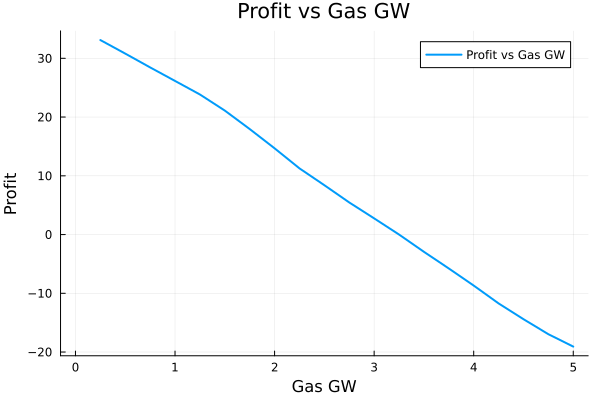

In [10]:
gas_grid = 0.0:0.25:5.0; # in GW (F is in GW)
profits = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"] for g in gas_grid];
plot(gas_grid, profits, xlabel="Gas GW", ylabel="Profit", label="Profit vs Gas GW", lw=2, legend=:topright, title="Profit vs Gas GW")

In [11]:
clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=16.0, gas_gw=0.01, ng_price=4.5)

Dict{String, Any} with 11 entries:
  "avg_price"    => 324.906
  "profit_wind"  => 0.433771
  "price"        => [46.5544, 35.2835, 58.0545, 30.2117, 39.5906, 34.4407, 48.0…
  "profit_solar" => -32.7109
  "status"       => "LOCALLY_SOLVED"
  "quantity"     => [4.61597 11.5 … 7.7089 9.10389e-9; 3.95377 11.5 … 6.5901 9.…
  "imports"      => [7.33958, 8.1567, 7.65714, 7.3126, 5.75803, 6.43132, 9.4142…
  "demand"       => [33.1004, 30.2106, 42.1801, 21.8135, 23.3955, 21.5856, 32.5…
  "profit_gas"   => -10.1707
  "surplus"      => 41876.0
  "cost"         => 3482.74

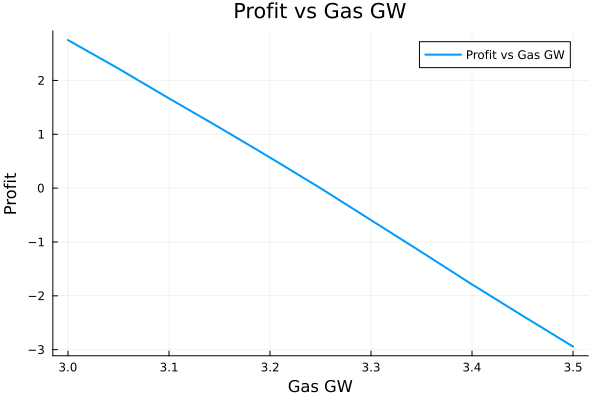

In [12]:
gas_grid = 3.0:0.05:3.5;
profits = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"] for g in gas_grid];
plot(gas_grid, profits, xlabel="Gas GW", ylabel="Profit", label="Profit vs Gas GW", lw=2, legend=:topright, title="Profit vs Gas GW")

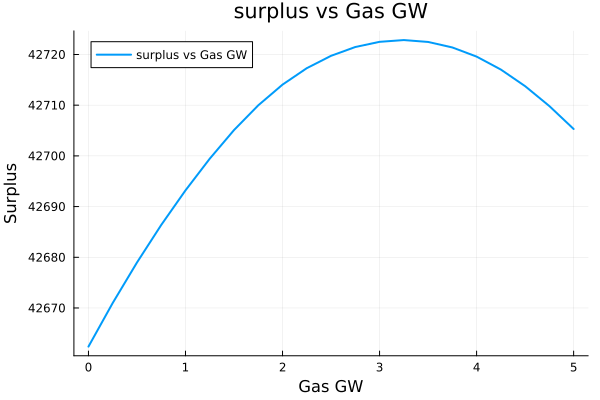

In [13]:
gas_grid = 0.0:0.25:5.0;
surplus = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["surplus"] for g in gas_grid];
plot(gas_grid, surplus, xlabel="Gas GW", ylabel="Surplus", label="surplus vs Gas GW", lw=2, legend=:topleft, title="surplus vs Gas GW")

## 2) Adding investment with social planner

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs - Fixed Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

Notice that we added the fixed costs to the problem, as we will be solving for the optimal level of wind and solar investment.

In [19]:
## Clear market based on cost minimization
function clear_market_invest(data::DataFrame, tech::DataFrame; ng_price = 3.5, tax=0.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods

    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end
    
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, gross_surplus[1:T]);
    @variable(model, gas_gw >= 0.0);
    @variable(model, wind_gw >= 0.0);
    @variable(model, solar_gw >= 0.0);

    # Maximize welfare including imports costs
    @objective(model, Max, sum(data.weights[t] * 
                (gross_surplus[t] - costs[t]) for t=1:T)
             - tech.F[5]*gas_gw  - tech.F[6]*wind_gw - tech.F[7]*solar_gw);

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    @constraint(model, [t=1:T], gross_surplus[t]==
                (data.a[t] - demand[t]) * demand[t] / data.b[t] 
            + demand[t]^2/(2*data.b[t]));

    # Define cost
    @constraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i]
                    + tech.c2[i] * quantity[t,i]^2/2 + tax * tech.e[i] * quantity[t,i]  for i=1:I)
        + (imports[t] - data.am[t])^2/(2 * data.bm[t]))
        # 
        # - subsidy * tech.renewable[i] * quantity[t,i] 
    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);


    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = JuMP.value.(costs);
        profit = sum(data.weights[t] * (p[t] * q[t,5] - tech.c[5] * q[t,5]) for t=1:T) - tech.F[5]*JuMP.value.(gas_gw);
        surplus = sum(data.weights[t] * (JuMP.value.(gross_surplus[t]) - JuMP.value.(costs[t])) for t=1:T) - 
            tech.F[5]*JuMP.value.(gas_gw)  - tech.F[6]*JuMP.value.(wind_gw) - tech.F[7]*JuMP.value.(solar_gw);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "gas_gw" => JuMP.value.(gas_gw),
            "wind_gw" => JuMP.value.(wind_gw),
            "solar_gw" => JuMP.value.(solar_gw),
            "profit_gas" => profit,
            "surplus" => surplus);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_invest (generic function with 1 method)

In [20]:
results = clear_market_invest(dfclust, tech, ng_price=3.5)

Dict{String, Any} with 12 entries:
  "avg_price"  => 31.9965
  "price"      => [41.37, 37.3354, 53.1652, 26.1088, 34.9667, 26.8047, 39.1364,…
  "gas_gw"     => 3.24985
  "status"     => "LOCALLY_SOLVED"
  "quantity"   => [4.61597 11.5 … 5.07327e-9 1.23752e-9; 3.95377 11.5 … 6.11413…
  "solar_gw"   => -9.93311e-9
  "imports"    => [7.08793, 8.28616, 7.48831, 6.98715, 5.5466, 6.03239, 8.85309…
  "demand"     => [33.5312, 30.0401, 42.5863, 22.1544, 23.7797, 22.2201, 33.256…
  "profit_gas" => 2.85004e-7
  "surplus"    => 42722.8
  "cost"       => [720.521, 557.858, 1077.5, 346.156, 444.8, 383.314, 639.492, …
  "wind_gw"    => -8.18488e-9

## 3) Adding investment with integer variables

We modify our mixed integer code with an additional "dummy" variable that allows for a corner solution at zero investment. If at zero investment firms make no money, then the zero profit condition is negative. Otherwise, the zero profit condition must be zero.

In [22]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; ng_price = 3.5, tax=0.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    M = 1e4;

    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, 0 <= K[5:I] <= 50.0);  # new capacity
    @variable(model, profit[5:I]); # tech annual profits, at most zero in equilibrium
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max
    @variable(model, u3[5:I], Bin);  # if tech is built


    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T, i=5:I], 
        quantity[t,i] <= u1[t,i] * 100.0);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= K[5]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= K[6] * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= K[7] * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= K[5] - M * (1.0-u2[t,5]));
    @constraint(model, [t=1:T], 
        quantity[t,6] >= K[6] * data.wind_cap[t] - M * (1.0-u2[t,6]));
    @constraint(model, [t=1:T], 
        quantity[t,7] >= K[7] * data.solar_cap[t] - M * (1.0-u2[t,7]));

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);

    # Constraints on optimality 
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - tax * tech.e[i] - shadow[t,i] 
        >= -M * (1.0-u1[t,i]));
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - tax * tech.e[i] - shadow[t,i] 
        <= 0.0);
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    # Definition of profit
    @constraint(model, profit[5] == 
                        sum(data.weights[t]*shadow[t,5] for t=1:T) - tech.F[5]);
    @constraint(model, profit[6] == 
                        sum(data.weights[t]*shadow[t,6]*data.wind_cap[t] for t=1:T) - tech.F[6]);
    @constraint(model, profit[7] == 
                        sum(data.weights[t]*shadow[t,7]*data.solar_cap[t] for t=1:T) - tech.F[7]);

    # Constraints on investment 
    @constraint(model, [i=5:I], profit[i] <= 0.0); # zero profits if investing
    @constraint(model, [i=5:I], profit[i] >= -M*(1.0-u3[i])); # zero profits if investing
    @constraint(model, [i=5:I], K[i] <= M*u3[i]); # capacity only positive if firms can make zero profit

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t] for t=1:T);		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => JuMP.value.(shadow),
            "K" => JuMP.value.(K),
            "profit" => JuMP.value.(profit),
            "u1" => JuMP.value.(u1),
            "u2" => JuMP.value.(u2),
            "u3" => JuMP.value.(u3));
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

In [30]:
invest_results = clear_market_foc(dfclust, tech, ng_price=3.5)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-05, 1e+04]
  Cost   [6e-03, 2e-01]
  Bound  [1e+00, 5e+01]
  RHS    [2e+00, 1e+04]
Presolving model
4601 rows, 2905 cols, 11695 nonzeros  0s
3201 rows, 1958 cols, 8556 nonzeros  0s
2672 rows, 1706 cols, 7369 nonzeros  0s
1868 rows, 1179 cols, 5037 nonzeros  0s
1551 rows, 954 cols, 4237 nonzeros  0s
1319 rows, 796 cols, 3652 nonzeros  0s
1288 rows, 775 cols, 3569 nonzeros  0s

Solving MIP model with:
   1288 rows
   775 cols (190 binary, 0 integer, 0 implied int., 585 continuous)
   3569 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   205.6956643     inf                  inf        0      0      0         0     0.3s
      

Dict{String, Any} with 13 entries:
  "avg_price" => 280.29
  "price"     => [41.37, 37.3354, 53.1652, 26.1088, 34.9667, 26.8047, 39.1364, …
  "profit"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [4.61597 11.5 … 2.13504e-13 0.0; 3.95377 11.5 … 1.82518e-13 0.…
  "imports"   => [7.08793, 8.28616, 7.48831, 6.98715, 5.5466, 6.03239, 8.85309,…
  "demand"    => [33.5312, 30.0401, 42.5863, 22.1544, 23.7797, 22.2201, 33.256,…
  "shadow"    => [31.37 14.2783 … 41.37 41.37; 27.3354 10.2437 … 37.3354 37.335…
  "u2"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 4121.41
  "K"         => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…

In [31]:
invest_results["K"][5]

3.249854606581327

## Exercise 1

Add carbon taxes to the model. Note that emissions are equal to the emissions rate times the quantity. The cost should be equal to the tax. (in class)

## Exercise 2

Add a subsidy to the model. One can think of the subsidy as a negative cost to renewable power. However, it is important that you also include a penalty to the overall subsidy spending but only after solving for the solution.

## Follow-up exercises

1. Consider a tax and a subsidy that reach the same target of emissions. What are the costs of each policy? How are the different technologies and components of welfare affected? [Note: This will require you to include emissions as an input or an output to the function.]